# Acoustic RTM

## Author: M. Ravasi

This notebook performs acoustic RTM using the same engine developed to compute the FWI velocity gradient. This is simply achieved by forcing the modelled data to be zero and simply compute the gradient with the observed data as adjoint source.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.ndimage import gaussian_filter
from pylops.basicoperators import Identity, Laplacian

from devito import configuration
from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.loss.empty import Empty
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

## Parameters 

In [3]:
# Model and aquisition parameters (in km, s, and Hz units)
par = {'nx':601,   'dx':0.015,    'ox':0,
       'nz':221,   'dz':0.015,    'oz':0,
       'ns':20,    'ds':0.300,    'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,    'or':0,   'rz':0,
       'nt':3000,  'dt':0.002,    'ot':0,
       'freq':15,  
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

## Acquisition set-up

In [4]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

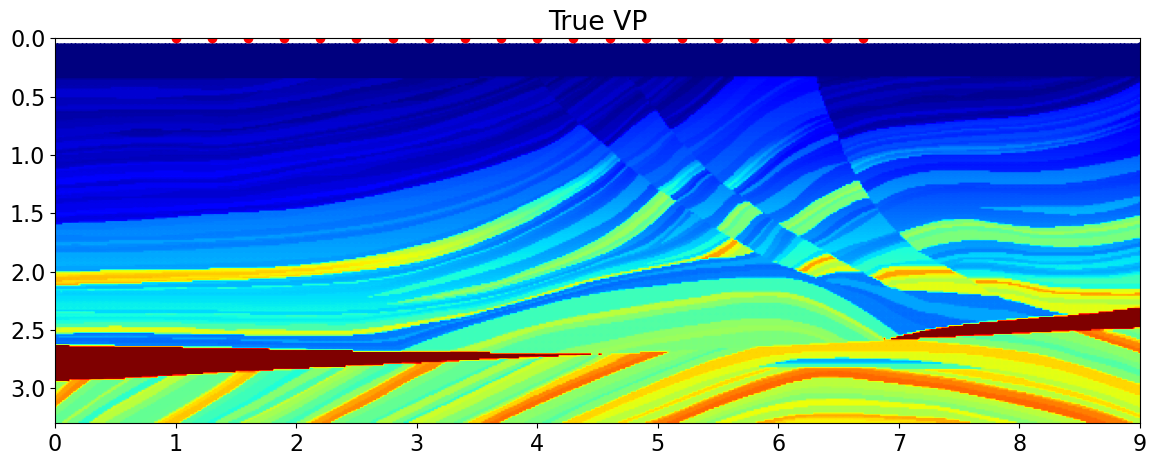

In [5]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
# plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

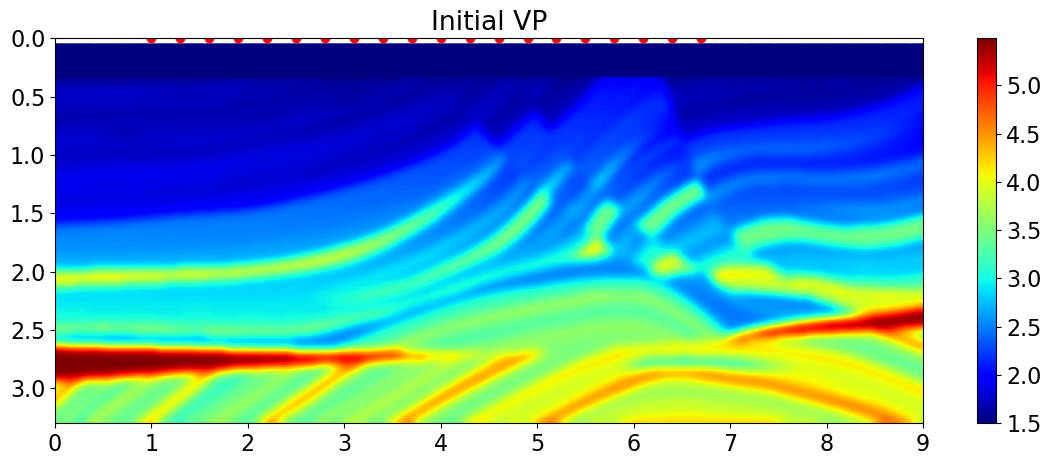

In [6]:
# RTM model by slightly smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[3, 3])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [7]:
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      clearcache=True)

In [8]:
# Model data
dobs, dtobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

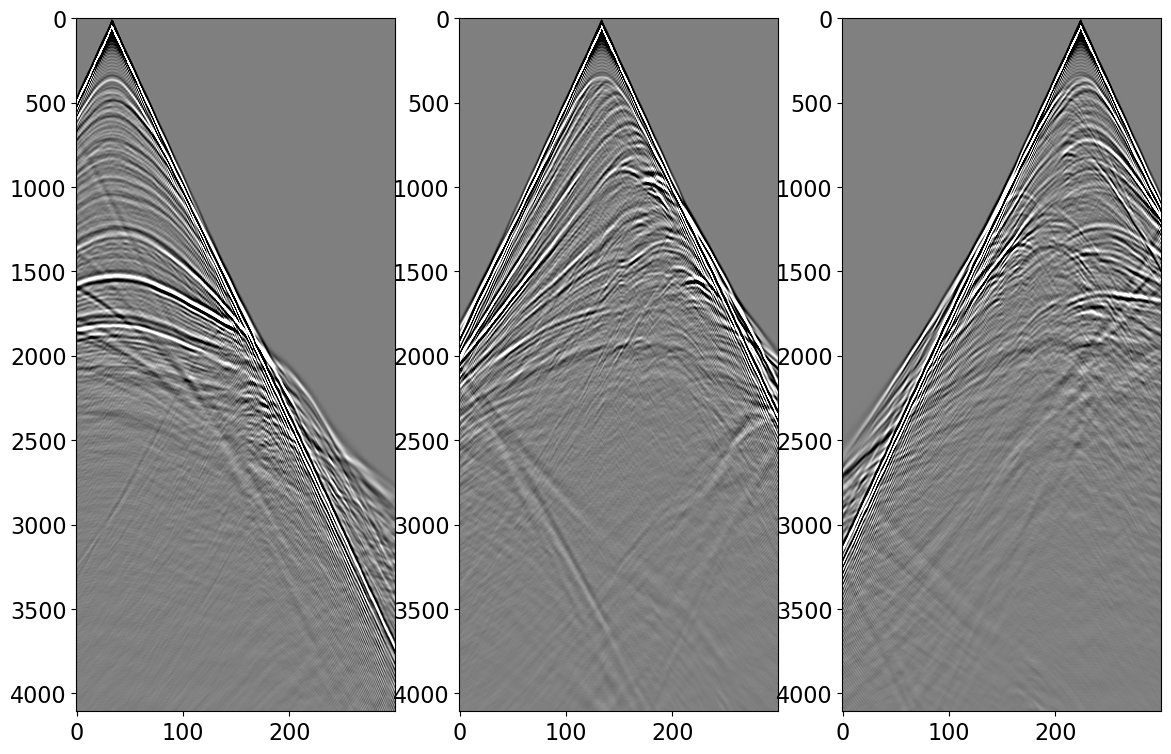

In [ ]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

## RTM

In [ ]:
# Create operator
rtmloss = Empty(dobs.reshape(par['ns'], -1))

ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,
                      vprange=(vp_true.min(), vp_true.max()),
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=rtmloss, clearcache=True)

In [11]:
# Compute image
postproc = PostProcessVP(scaling=1, mask=msk)
_, rtm = ainv._loss_grad(vp_init, postprocess=postproc.apply)
rtm /= rtm.max()

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
# Apply post-processing with Laplacian
Dop = Laplacian((par['nx'], par['nz']))
rtm_lap = Dop @ rtm
rtm_lap /= rtm_lap.max()

In [13]:
# Apply post-processing with Smoothing
nsmooth = 2
smooth = np.ones(nsmooth)/nsmooth
rtm_lf = - rtm + filtfilt(smooth, 1, filtfilt(smooth, 1, rtm).T).T
rtm_lf /= rtm_lf.max()

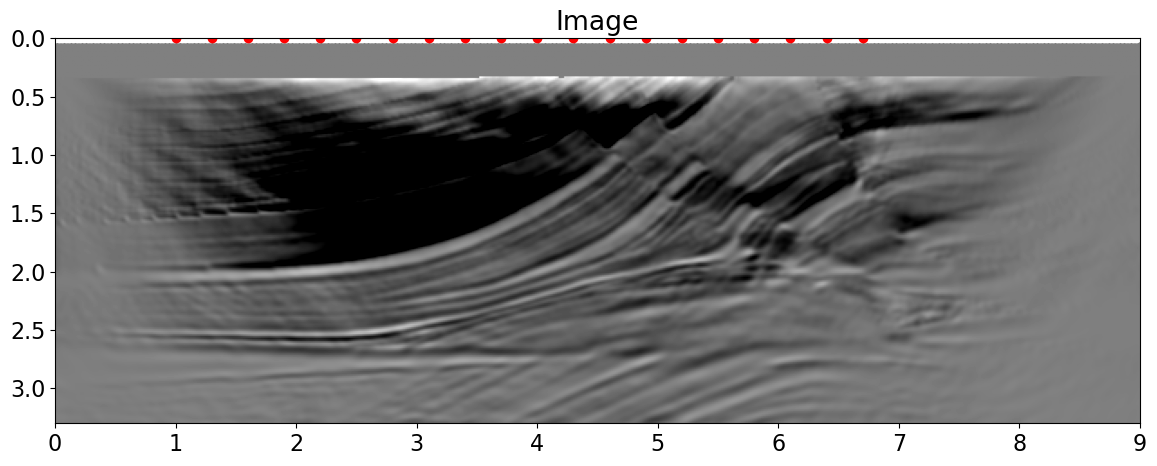

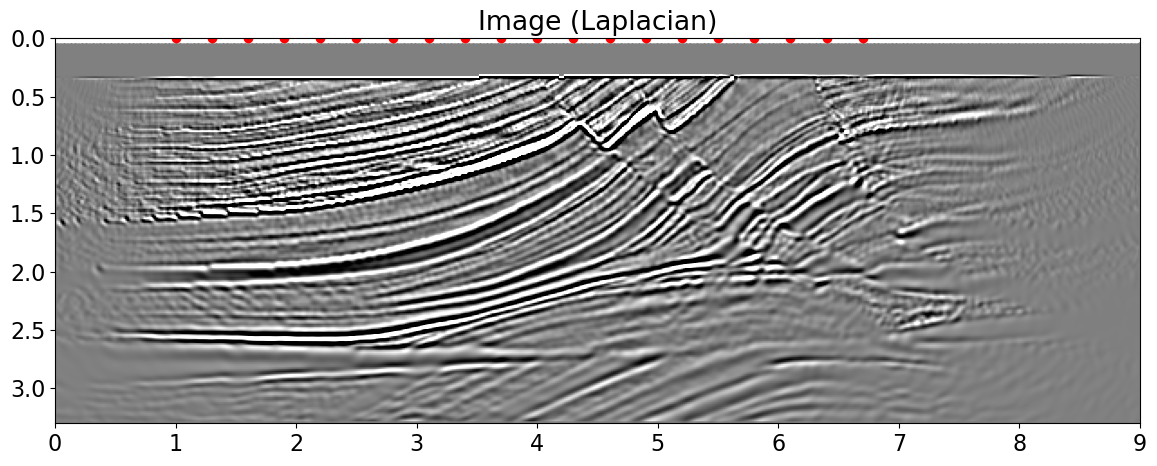

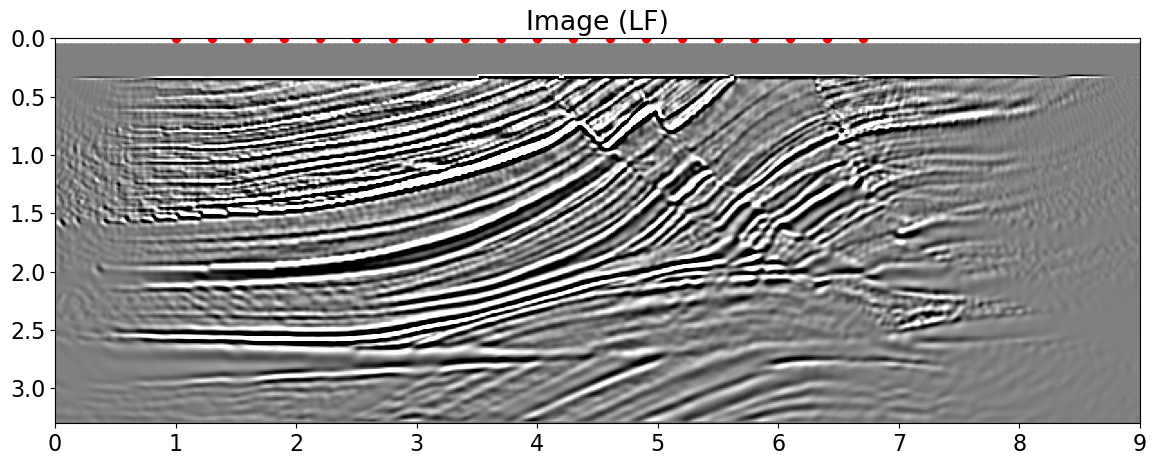

In [14]:
# Visualize with gain
gain = np.power(z, 2)

plt.figure(figsize=(14, 5))
plt.imshow((rtm * gain).T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Image')
plt.axis('tight')

plt.figure(figsize=(14, 5))
plt.imshow((rtm_lap * gain).T, cmap='gray', vmin=-1e-2, vmax=1e-2, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Image (Laplacian)')
plt.axis('tight')

plt.figure(figsize=(14, 5))
plt.imshow((rtm_lf * gain).T, cmap='gray', vmin=-1e-2, vmax=1e-2, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Image (LF)')
plt.axis('tight');